In [ ]:
# default_exp samplers.circuit_samplers

# Circuit Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction circuits

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash, unpack
from qsam.fault_generators import Depolar

import numpy as np
import itertools as it

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES,
               }

In [ ]:
#export
class Sampler:
    def __init__(self, circuit, simulator):
        self.circuit = circuit
        self.simulator = simulator
        self.n_qubits = circuit.n_qubits
        
    def run(self, n_samples, sample_range, err_params, fail_patterns, var=math.Wilson_var):
        fail_cnts = np.zeros(len(sample_range))
        partitions = [partition(self.circuit, GATE_GROUPS[k]) for k in err_params.keys()]
        
        for i, sample_pt in enumerate(sample_range):
            
            p_phy = np.array(list(err_params.values())) * sample_pt
            
            for _ in range(n_samples):
                sim = self.simulator(self.n_qubits)
                faults = Depolar.faults_from_probs(partitions, p_phy)
                fault_circuit = Depolar.gen_circuit(len(self.circuit), faults)
                msmt = sim.run(self.circuit, fault_circuit)
                if msmt in fail_patterns:
                    fail_cnts[i] += 1
                    
        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

Test sampler on GHZ circuit

In [ ]:
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}
fail_patterns = ['1']

sam = Sampler(ghz, CHP)
p_L, std = sam.run(1000, sample_range, err_params, fail_patterns)

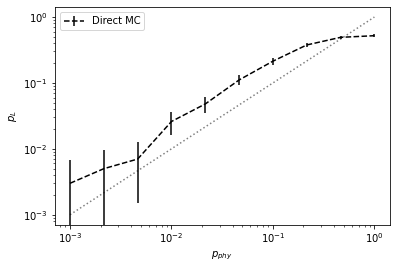

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

sample_range = np.logspace(-3,0,10)

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$p_{phy}$')
plt.legend();

In [ ]:
#export

class SubsetSampler:
    def __init__(self, circuit, simulator):
        self.circuit = circuit
        self.simulator = simulator
        self.n_qubits = circuit.n_qubits
        
    @staticmethod
    def subset_occurence(partitions, partition_w_vecs, p_phy_per_partition):
        """Return (weight)x(p_phys) (parition) subset occurance matrix transforming p_SS vector to p_L vector"""
        n_partition_elems = np.array([len(p) for p in partitions])
        Aws = np.array([math.binom(w_vec, n_partition_elems, p_phy_per_partition) for w_vec in partition_w_vecs])
        Aws = np.product(Aws, axis=-1) # mult Aws for multi-parameter, i.e. multi-partitions
        return Aws
    
    @staticmethod
    def weight_vectors(w_max, w_exclude={}):
        w_exclude = set((w,) if isinstance(w, int) else w for w in w_exclude)
        w_maxs = [w_max] if isinstance(w_max, int) else w_max
        
        w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_maxs]
        w_vecs = list(it.product( *w_upto_w_maxs ))
        return w_vecs
        
    def run(self, n_samples, sample_range, err_params, fail_patterns, w_max, w_exclude, var=math.Wilson_var):
        
        p_phy_per_partition = np.array([[p_phy * mul for p_phy in sample_range] for mul in err_params.values()]).T
        partitions =[partition(self.circuit, GATE_GROUPS[k]) for k in err_params.keys()]
        
        w_vecs = SubsetSampler.weight_vectors(w_max, w_exclude)
        Aws = SubsetSampler.subset_occurence(partitions, w_vecs, p_phy_per_partition)
        
        cnts = np.zeros((len(w_vecs))) + 1 # one virtual sample to avoid div0
        fail_cnts = np.zeros((len(w_vecs)))
        
        for i in range(n_samples):
            sim = self.simulator(self.n_qubits)
            ss_idx = cnts.argmin()
            w_vec = w_vecs[ss_idx]
            faults = Depolar.faults_from_weights(partitions, w_vec)
            fault_circuit = Depolar.gen_circuit(len(self.circuit), faults)
            msmt = sim.run(self.circuit, fault_circuit)
            if msmt in fail_patterns:
                fail_cnts[ss_idx] += 1
            cnts[ss_idx] += 1
        
        pws = ( fail_cnts / (cnts - 1) )[:,None]
         
        w_vecs_inclusive = SubsetSampler.weight_vectors(w_max, {})
        Aws_inclusive = SubsetSampler.subset_occurence(partitions, w_vecs_inclusive, p_phy_per_partition)
        Aws_upper = 1 - np.sum(Aws_inclusive, axis=0)
        
        p_L_low = np.sum(Aws * pws, axis=0)
        p_L_up = p_L_low + Aws_upper
        std = np.sqrt( np.sum( Aws**2 * var(pws, n_samples), axis=0 ) )
        
        return p_L_low, p_L_up, std

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}
fail_patterns = ['1']

sam = SubsetSampler(ghz, CHP)
p_L_low, p_L_up, ss_std = sam.run(100, sample_range, err_params, fail_patterns, w_max=2, w_exclude={1})

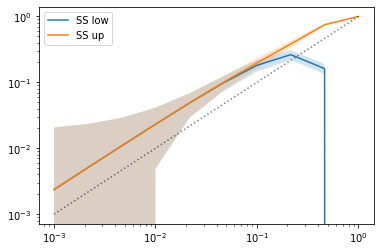

In [ ]:
#slow
#hide_input
import matplotlib.pyplot as plt

sample_range = np.logspace(-3,0,10)

plt.plot(sample_range, p_L_low, label="SS low")
plt.fill_between(sample_range, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(sample_range, p_L_up, label="SS up")
plt.fill_between(sample_range, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

Now, we can compare the results of the direct and subset sampler:

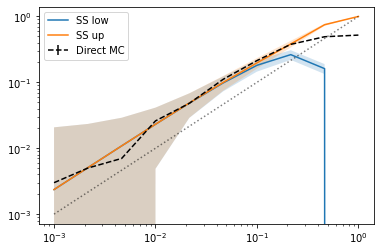

In [ ]:
#slow
#hide_input
import matplotlib.pyplot as plt

sample_range = np.logspace(-3,0,10)

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(sample_range, p_L_low, label="SS low")
plt.fill_between(sample_range, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(sample_range, p_L_up, label="SS up")
plt.fill_between(sample_range, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

We can plot the occurence probabilities for each subset as a function of the physical failure rate:

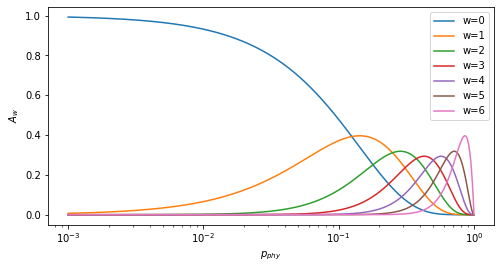

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

part = partition(ghz, GATE_GROUPS['p'])
Aw = np.array([[math.binom(w, len(part)+1, p) for p in p_phy] for w in range(len(part)+1)])
plt.figure(figsize=(8,4))
plt.plot(p_phy, Aw.T, label=[f'w={i}' for i in range(len(part)+1)]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

The `w=0` fault-weight subset occurs by far most often for smaller rates. However, for this subset we know in advance that no logical failure can occur. Thus, we gain a lot by excluding it from the sampling process. Futhermore, for fault-tolerant circuits, we can be sure that also a sampling from the `w=1` subsets will not cause a logical error by definition of fault tolerance. In these regions the `SubsetSampler` becomes far more efficient.

# Multi-parameter/partition noise
It is more realistic to give the different partitions, i.e. 1-qubit or 2-qubit gates etc. different physical error rates. Similarly to the single-parameter case we can take a look at the occurance of the 2-partition-subsets:

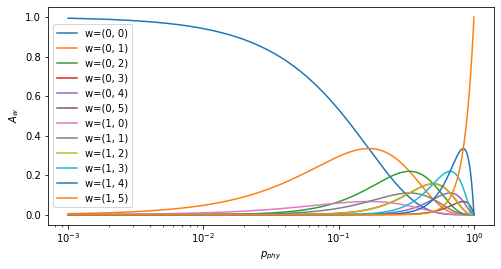

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

err_params = {'p1':p_phy, 'p2':p_phy}
partitions = [partition(ghz, GATE_GROUPS[g]) for g in err_params.keys()]
p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
w_max_vec = [len(p) for p in partitions]
w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec]
w_vecs = list(it.product( *w_upto_w_maxs ))
Aws = SubsetSampler.subset_occurence(partitions, w_vecs, p_phys_mat)

plt.figure(figsize=(8,4))
plt.plot(p_phy, Aws.T, label=[f'w={i}' for i in w_vecs]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

As we can see the `(0,0)` subset has the largest impact for decreasing physical error rates. Thus we gain a lot by excluding it. This is how we run the subset sampler with multi-parameter noise and by manually excluding a subset.

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p1': 1, 'p2': 0.5}
fail_patterns = ['1']

sam = SubsetSampler(ghz, CHP)
p_L_low, p_L_up, ss_std = sam.run(1000, sample_range, err_params, fail_patterns, w_max=[1,3], w_exclude={(0,0)})

sam = Sampler(ghz, CHP)
p_L, std = sam.run(1000, sample_range, err_params, fail_patterns)

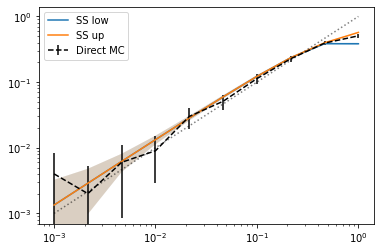

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

sample_range = np.logspace(-3,0,10)

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(sample_range, p_L_low, label="SS low")
plt.fill_between(sample_range, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(sample_range, p_L_up, label="SS up")
plt.fill_between(sample_range, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

In [ ]:
#export
#hide

def calc_w_max(p_max, delta_max, n_partition_elems):
    """Calculate weight cutoff at p_max for delta_max"""
    
    delta = 1
    for w_max in range(n_partition_elems+1):
        delta -= math.binom(w_max, n_partition_elems, p_max)
        if delta < delta_max: 
            break
    return w_max

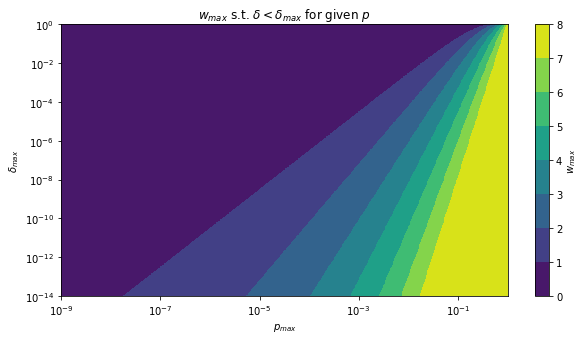

In [ ]:
#slow
#hide

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc_w_max(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()